# Data Quality

This notebook performs the following tasks:

1. It compares the characters obtained with the two data acquisition methods (i.e., Web Scraping and API).

2. It evaluates the quality of the data collected for the Mario Graph Database. It focuses on these three primary dimensions:
    - **Completeness**
    - **Redundancy**
    - **Consistency**

    
    For each data quality dimension, it checks the data quality of both the raw data and the integrated and enriched data.
    
    Furthermore, for the game's release year, we checked also for **Accuracy** and **Currency**.

## Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-integration: Load the initial raw datasets
bosses_df = pd.read_csv("data/bosses_df.csv")
characters_df = pd.read_csv("data/characters_df.csv")
enemies_df = pd.read_csv("data/enemies_df.csv")
games_df = pd.read_csv("data/games_data.csv")
sales_df = pd.read_csv("data/sales_data.csv")
relationships_df = pd.read_csv("data/general_character_relationships.csv")

# Post-integration: Load the final and processed (integrated and enriched) datasets
merged_data = pd.read_csv("data/merged_data.csv")
merged_data_api = pd.read_csv("data/merged_data_API.csv")

print("All datasets loaded successfully.")

All datasets loaded successfully.


## Compare characters obtained with Scraping and API

Let's analyze how the different data sources complement each other. This is done by comparing the character lists from the scraped data and the API data.



In [ ]:
# Extract unique characters from the final merged datasets
# For scraped data, the main entity is 'Figure'
scraped_chars = set(merged_data['Figure'].dropna().str.lower().str.strip())

# For API data, characters can be in either 'Figure' or 'RelatedCharacter'
api_figures = set(merged_data_api['Figure'].dropna().str.lower().str.strip())
api_related = set(merged_data_api['RelatedCharacter'].dropna().str.lower().str.strip())
api_chars = api_figures.union(api_related)

# 1. Character coverage analysis
common_chars = scraped_chars.intersection(api_chars)
unique_to_scraped = scraped_chars.difference(api_chars)
unique_to_api = api_chars.difference(scraped_chars)

print("---Character coverage analysis---")
print(f"Total unique characters in Scraped Data: {len(scraped_chars)}")
print(f"Total unique characters in API Data: {len(api_chars)}")
print(f"\nCharacters found in BOTH datasets: {len(common_chars)}")
print(f"Characters UNIQUE to Scraped Data: {len(unique_to_scraped)}")
print(f"Characters UNIQUE to API Data: {len(unique_to_api)}")

# 2. Relationship and Species Comparison
# The scraped data primarily links figures to games, not to other figures.
# The API data is the main source for character-to-character relationships.
# We can, however, compare the 'Species' data for common characters.

discrepancies = []
for char in sorted(list(common_chars)):
    # Get species from scraped data (taking the first non-null value if multiple exist)
    scraped_species_series = merged_data.loc[merged_data['Figure'].str.lower().str.strip() == char, 'Species'].dropna()
    scraped_species = scraped_species_series.iloc[0] if not scraped_species_series.empty else None

    # Get species from API data (checking both Figure and RelatedCharacter columns)
    api_species_fig = merged_data_api.loc[merged_data_api['Figure'].str.lower().str.strip() == char, 'FigureSpecies'].dropna()
    api_species_rel = merged_data_api.loc[merged_data_api['RelatedCharacter'].str.lower().str.strip() == char, 'RelatedCharacterSpecies'].dropna()
    api_species_series = pd.concat([api_species_fig, api_species_rel])
    api_species = api_species_series.iloc[0] if not api_species_series.empty else None

    # Compare species from both sources
    if scraped_species and api_species and (scraped_species.lower() != api_species.lower()):
        discrepancies.append({
            "Character": char,
            "Scraped Species": scraped_species,
            "API Species": api_species
        })

print("\n---Species Data Discrepancies---")
if discrepancies:
    discrepancy_df = pd.DataFrame(discrepancies)
    print(discrepancy_df.to_string(index=False))
else:
    print("No species mismatches found for common characters.")


---Character coverage analysis---
Total unique characters in Scraped Data: 389
Total unique characters in API Data: 363

Characters found in BOTH datasets: 88
Characters UNIQUE to Scraped Data: 301
Characters UNIQUE to API Data: 275

---Species Data Discrepancies---
No species mismatches found for common characters.


## Data Quality Assessment **before** Data Integration

Assessing the quality of the raw data.

### 1) Completeness

In [ ]:
def completeness_score(df, name):
    total_cells = df.size
    missing_cells = df.isnull().sum().sum()
    score = 100 * (1 - missing_cells / total_cells) if total_cells > 0 else 100
    print(f"Completeness of '{name}': {score:.2f}%")
    return score

raw_datasets = {
    "characters_df": characters_df, "bosses_df": bosses_df, "enemies_df": enemies_df,
    "games_df": games_df, "sales_df": sales_df, "relationships_df": relationships_df
}

completeness_scores_before = {name: completeness_score(df, name) for name, df in raw_datasets.items()}

Completeness of 'characters_df': 98.38%
Completeness of 'bosses_df': 81.81%
Completeness of 'enemies_df': 100.00%
Completeness of 'games_df': 100.00%
Completeness of 'sales_df': 99.55%
Completeness of 'relationships_df': 100.00%


Check for missing values in the key datasets.

In [ ]:
# Completeness of 'Species' in raw character and boss data (not present for enemies)
total_bosses = len(bosses_df)
missing_boss_species = bosses_df['Species'].isnull().sum()
completeness_boss_species = (1 - missing_boss_species / total_bosses) * 100

total_chars = len(characters_df)
missing_char_species = characters_df['Species'].isnull().sum()
completeness_char_species = (1 - missing_char_species / total_chars) * 100

print(f"Completeness of 'Species' in bosses_df: {completeness_boss_species:.2f}%")
print(f"Completeness of 'Species' in characters_df: {completeness_char_species:.2f}%")

# Completeness of 'Year' and 'Console' in games_df
total_games = len(games_df)
missing_years = games_df['Year'].isnull().sum()
missing_consoles = games_df['Console'].isnull().sum()
completeness_year = (1 - missing_years / total_games) * 100
completeness_console = (1 - missing_consoles / total_games) * 100

print(f"Completeness of 'Year' in games_df: {completeness_year:.2f}%")
print(f"Completeness of 'Console' in games_df: {completeness_console:.2f}%")

Completeness of 'Species' in bosses_df: 27.23%
Completeness of 'Species' in characters_df: 93.51%
Completeness of 'Year' in games_df: 100.00%
Completeness of 'Console' in games_df: 100.00%


The low Completeness score of 'Species' for the bosses is due to the fact that the Mario wiki website often does not provide this information in the bosses pages.

### 2) Redundancy

In [ ]:
print("--Character data--")
print(f"Duplicate rows in characters_df: {characters_df.duplicated().sum()}")
print(f"Duplicate rows in enemies_df: {enemies_df.duplicated().sum()}")
print(f"Duplicate rows in bosses_df: {bosses_df.duplicated().sum()}")
print("--Game data--")
print(f"Duplicate rows in games_df: {games_df.duplicated().sum()}")
print(f"Duplicate rows in sales_df: {sales_df.duplicated().sum()}")

--Character data--
Duplicate rows in characters_df: 176
Duplicate rows in enemies_df: 42
Duplicate rows in bosses_df: 10
--Game data--
Duplicate rows in games_df: 0
Duplicate rows in sales_df: 6


### 3) Consistency

The 'Console' column in games_df is a perfect example of inconsistency, therefore we can measure the variety of console names before standardization.

In [ ]:
# Number of unique console names before cleaning
print(f"Number of unique 'Console' values in games_df: {games_df['Console'].nunique()}")
print("\nTop 20 most frequent raw console names:")
print(games_df['Console'].value_counts().nlargest(20))

Number of unique 'Console' values in games_df: 73

Top 20 most frequent raw console names:
Console
Nintendo Switch                36
Arcade                         33
Nintendo 3DS                   30
Game Boy Advance               27
Wii                            24
Nintendo DS                    23
Nintendo GameCube              23
Wii U                          22
Game Boy                       15
Nintendo 64                    14
Game & Watch                   14
Famicom / NES                  13
Famicom Disk System            11
Super Famicom / SNES           11
MS-DOS                         11
Game Boy Color                 10
Nintendo DSi (DSiWare)          9
SNES                            9
Game Boy Advance (e-Reader)     5
Satellaview (Super Famicom)     4
Name: count, dtype: int64


## Data Quality Assessment **after** Data Integration

Assessing the two final, integrated files used to build the graph model.

### 1) Completeness

In [ ]:
processed_datasets = {"merged_data": merged_data, "merged_data_API": merged_data_api}
completeness_scores_after = {name: completeness_score(df, name) for name, df in processed_datasets.items()}

Completeness of 'merged_data': 87.50%
Completeness of 'merged_data_API': 79.18%


These values are penalized by the species and sales columns. Moreover, the final merged_data file is a combination of multiple raw files, so a direct comparison of the overall score may be less meaningful.

How has the completeness of 'Species' and 'Sales' changed?

In [ ]:
# Completeness in the final merged_data
total_merged = len(merged_data)
missing_merged_species = merged_data['Species'].isnull().sum()
missing_merged_sales = merged_data['Sales'].isnull().sum()

completeness_merged_species = (1 - missing_merged_species / total_merged) * 100
completeness_merged_sales = (1 - missing_merged_sales / total_merged) * 100

print(f"Completeness of 'Sales' in final merged_data: {completeness_merged_sales:.2f}%")
print(f"Completeness of 'Species' in final merged_data: {completeness_merged_species:.2f}%")

# Completeness of species in the API data after enrichment
total_api_rels = len(merged_data_api)
missing_figure_species = merged_data_api['FigureSpecies'].isnull().sum()
completeness_api_species = (1 - missing_figure_species / total_api_rels) * 100
missing_related_character_species = merged_data_api['RelatedCharacterSpecies'].isnull().sum()
completeness_api_related_species = (1 - missing_related_character_species / total_api_rels) * 100

print(f"Completeness of 'FigureSpecies' in final API data: {completeness_api_species:.2f}%")
print(f"Completeness of 'RelatedCharacterSpecies' in final API data: {completeness_api_related_species:.2f}%")

Completeness of 'Sales' in final merged_data: 63.04%
Completeness of 'Species' in final merged_data: 49.44%
Completeness of 'FigureSpecies' in final API data: 51.55%
Completeness of 'RelatedCharacterSpecies' in final API data: 44.37%


### 2) Redundancy

The data integration step handled the duplicates, let's verify this.

In [ ]:
print(f"Duplicate rows in merged_data (on Figure, Game, Console, Year, Relation): {merged_data.duplicated(subset=['Figure', 'Game', 'Console', 'Year', 'Relation']).sum()}")
print(f"Duplicate rows in merged_data_API (on Figure, RelatedCharacter, RelationshipType): {merged_data_api.duplicated(subset=['Figure', 'RelatedCharacter', 'RelationshipType']).sum()}")

Duplicate rows in merged_data (on Figure, Game, Console, Year, Relation): 0
Duplicate rows in merged_data_API (on Figure, RelatedCharacter, RelationshipType): 0


### 3) Consistency

The data integration step standardized console names: verify that the 'Console' column is now clean and standardized.

In [ ]:
print(f"Number of unique 'Console' values in merged_data: {merged_data['Console'].nunique()}")
print("Standardized console value counts:")
print(merged_data['Console'].value_counts())

Number of unique 'Console' values in merged_data: 27
Standardized console value counts:
Console
Switch                 1230
3DS                    1115
Wii                     869
GC                      558
WiiU                    532
DS                      480
GBA                     316
N64                     299
Mobile                  267
SNES                    261
Arcade                  259
NES                     152
Game & Watch            132
PC                       96
GB                       75
GBC                      73
Switch 2                 69
famicom disk system      41
Atari 8-bit              18
2600                     18
Atari 7800               18
Other Computer           17
Virtual Boy              15
Other Handheld           13
Intellivision            12
ColecoVision             12
Philips CD-i             11
Name: count, dtype: int64


We can quantify the reduction in categorical complexity.

In [ ]:
unique_consoles_before = games_df['Console'].nunique()
unique_consoles_after = merged_data['Console'].nunique()

print(f"Reduced 'Console' variations from {unique_consoles_before} to {unique_consoles_after} (percentage reduction: {((unique_consoles_before - unique_consoles_after) / unique_consoles_before) * 100:.2f}%)")

Reduced 'Console' variations from 73 to 27 (percentage reduction: 63.01%)


### Other Dimensions: Accuracy and Currency

In [ ]:
# Accuracy analysis

# Check the range of the 'Year' column
min_year = merged_data['Year'].min()
max_year = merged_data['Year'].max()
current_year = pd.to_datetime('today').year

print(f"Minimum year in data: {min_year}")
print(f"Maximum year in data: {max_year}")

if max_year > current_year:
    print(f"Warning: Data contains future release years (up to {max_year}).")
if min_year < 1980:
    print(f"Warning: Data contains very old release years (down to {min_year}), which might be worth verifying.")

Minimum year in data: 1981
Maximum year in data: 2025


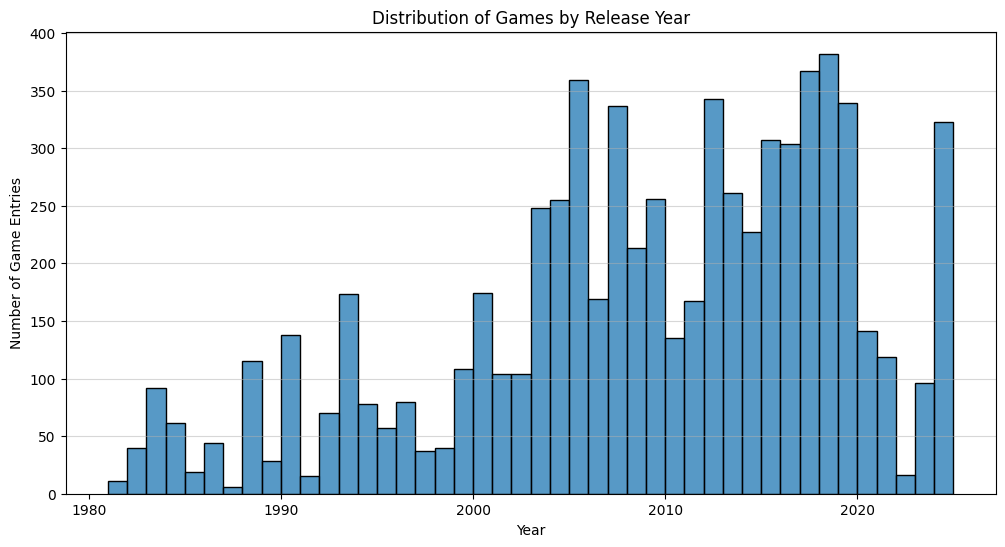

In [ ]:
# Currency analysis

plt.figure(figsize=(12, 6))
sns.histplot(merged_data['Year'].dropna(), bins=range(int(min_year), int(max_year) + 1), kde=False)
plt.title('Distribution of Games by Release Year')
plt.xlabel('Year')
plt.ylabel('Number of Game Entries')
plt.grid(axis='y', alpha=0.5)
plt.show()

## Conclusions

- The API is the primary source for character relationships, while scraped data provides game appearance details, making the sources highly complementary.
- The integration process reduced console name variations by 63%, significantly improving consistency.
- Table-level completeness is pretty high, while the score for 'Species' and 'Sales' attributes is lower (around 50% and 63% respectively). This is due to the available data sources.
- The temporal data allows for accurate time-based analysis.
- The distribution reflects the Mario franchise's history, especially its high output during the Wii and DS era, and recently with the Switch.